In [1]:
from __future__ import division
from pyoperators import pcg
from pysimulators import profile

# QUBIC packages
import qubic
from qubicpack.utilities import Qubic_DataDir
from qubic.data import PATH
from qubic.io import read_map
from qubic import QubicSkySim as qss
import sys
sys.path.append('/Users/mregnier/Desktop/PhD Regnier/mypackages')


import Acquisition as Acq

# Display packages
import healpy as hp
import matplotlib.pyplot as plt

# FG-Buster packages
import component_model as c
import mixing_matrix as mm

# General packages
import numpy as np
import pysm3
import warnings
from qubic import QubicSkySim as qss
import pysm3.units as u
from importlib import reload
from pysm3 import utils

from qubic import SpectroImLib as sp
from importlib import reload
import gc
import copy
from pyoperators import *
import myPCG as mypcg


# PyOperators packages
from pyoperators import (
    BlockColumnOperator, BlockDiagonalOperator, BlockRowOperator,
    CompositionOperator, DiagonalOperator, I, IdentityOperator,
    MPIDistributionIdentityOperator, MPI, proxy_group, ReshapeOperator,
    rule_manager, pcg, Operator)

from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator
warnings.filterwarnings("ignore")
# %matplotlib inline

## Now QUBIC and Planck acquisitions used for reconstruction

def integration(nu_min, nu_max, Nintegr, sky_config, d, fwhm_subbands = None):
    print(f'Integration from {nu_min:.2f} to {nu_max:.2f} GHz with {Nintegr} steps')
    obj = Acq.QubicIntegrated(d, Nsub=Nintegr, Nrec=Nintegr)
    if Nintegr == 1:
        allnus = np.array([np.mean([nu_min, nu_max])])
    else:
        allnus = np.linspace(nu_min, nu_max, Nintegr)
    m = obj.get_PySM_maps(sky_config, nus=allnus)
    
    if fwhm_subbands is not None:
        for i in range(Nintegr):
            C = HealpixConvolutionGaussianOperator(fwhm=fwhm_subbands[i])
            m[i] = C(m[i])
    
    return np.array([np.mean(m, axis=0)])


# # %config InlineBackend.figure_format='retina'
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/Users/hamilton/Python/GitQubic/qubic/qubic/scripts/Tutorials-MapMaking/


In [6]:
reload(Acq)
nside = 256
relative_bandwidth = 0.25
band = 150
band_planck = 143
seed = 42
noiseless = False
effective_duration = 3e0
rwplanck = 1.
tol = 1e-40
noise_planck_level = 1
noise_qubic_level = 1


npointings = 2000
Nf_TOD = 10
Nf_recon = 5
fact_sub = 2

reload(Acq)

# Repository for dictionary
#global_dir = Qubic_DataDir()
#print(global_dir)
dictfilename = 'dicts/pipeline_demo.dict'

# Read dictionary chosen
d_TOD = qubic.qubicdict.qubicDict()
d_TOD.read_from_file(dictfilename)

d_TOD['nf_recon'] = Nf_TOD
d_TOD['nf_sub'] = Nf_TOD
d_TOD['nside'] = nside
npix=12*d_TOD['nside']**2

# d_TOD['RA_center'] = 100
# d_TOD['DEC_center'] = -157
# d_TOD['RA_center'] = 0
# d_TOD['DEC_center'] = -57
ragc, decgc = qubic.gal2equ(-90,0)
d_TOD['RA_center'] = ragc
d_TOD['DEC_center'] = decgc
center = qubic.equ2gal(d_TOD['RA_center'], d_TOD['DEC_center'])

d_TOD['effective_duration'] = effective_duration
d_TOD['npointings'] = npointings
d_TOD['tol'] = 5e-4
d_TOD['filter_nu'] = band * 1e9
d_TOD['photon_noise'] = False#not noiseless
d_TOD['noiseless'] = noiseless
d_TOD['config'] = 'FI'
d_TOD['MultiBand'] = True
d_TOD['planck'] = True
d_TOD['dtheta'] = 15
#d_TOD['synthbeam_dtype'] = float

print('*************** Noise **************')
print('Noisless:      {}'.format(d_TOD['noiseless']))
print('Photon Noise:  {}'.format(d_TOD['photon_noise']))
print('************************************')

#sky_config = {'cmb':42}
#sky_config = {'dust':'d0'}
sky_config = {'cmb':3, 'dust':'d0'}

reload(Acq)
qubic_acquisition = Acq.QubicIntegrated(d_TOD, Nsub=Nf_TOD, Nrec=Nf_TOD)
cov = qubic_acquisition.get_coverage()

C = HealpixConvolutionGaussianOperator(fwhm=np.radians(1))
covconv = C(cov)
covnorm = covconv/covconv.max()
threshold = 0.1
#seenpix = generate_circular_mask(256, 10, center[0], center[1])
seenpix = covnorm > threshold
notseenpix = covnorm < threshold

m_sub = qubic_acquisition.get_PySM_maps(sky_config, qubic_acquisition.allnus)
print(m_sub.shape)

tod_nus_edge = qubic_acquisition.nus_edge

/Users/hamilton/Python/GitQubic/qubic/qubic/scripts/Tutorials-MapMaking/
/Users/hamilton/Python/GitQubic/qubic/qubic/scripts/Tutorials-MapMaking/
*************** Noise **************
Noisless:      False
Photon Noise:  False
************************************
/Users/hamilton/Python/GitQubic/qubic/qubic/scripts/Tutorials-MapMaking/
You asked 2000 pointings with repeat strategy so I will provide 666 pointings repeated 3 times.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
(10, 786432, 3)


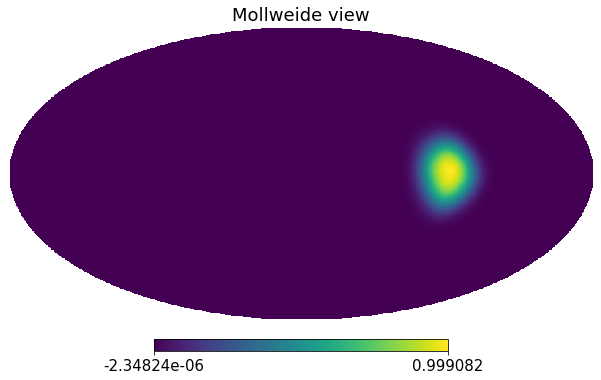

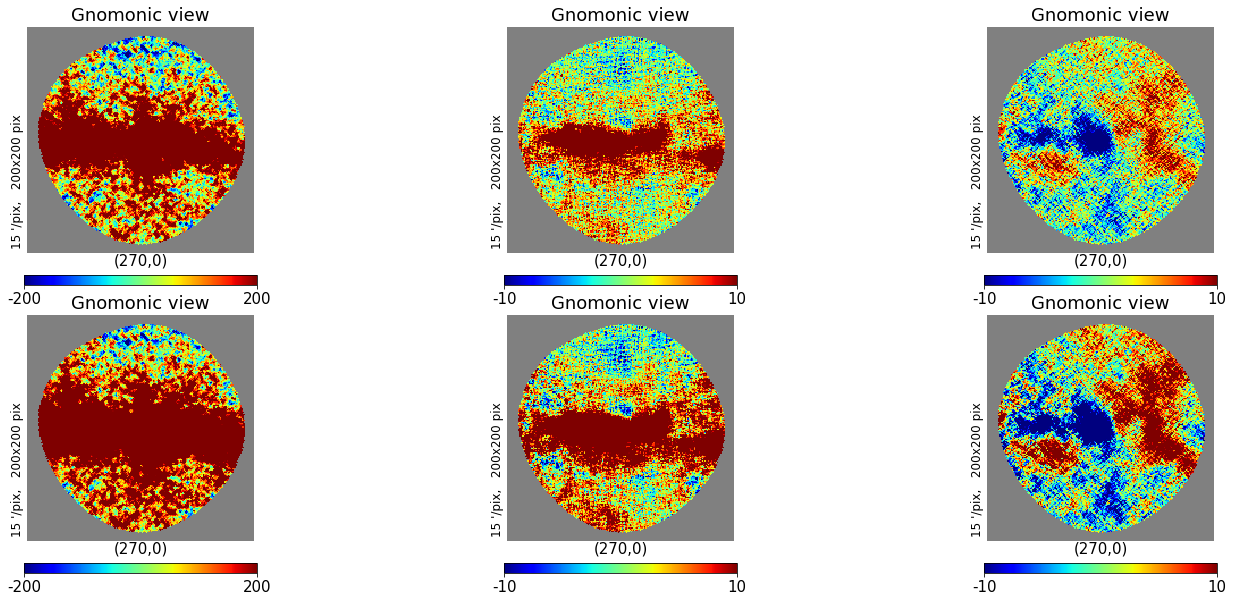

In [7]:
rc('font', size=15)
rc('figure', figsize=(20, 8))

hp.mollview(covnorm)
figure()

for i in range(3):
    if i==0:
        mini = -200
        maxi = 200
    else:
        mini = -10
        maxi = 10
    mlo = m_sub[0,:,i].copy()
    mlo[~seenpix] = hp.UNSEEN
    mhi = m_sub[-1,:,i].copy()
    mhi[~seenpix] = hp.UNSEEN
    hp.gnomview(mlo, reso=15, rot=center, sub=(2,3,i+1), cmap='jet', min=mini, max=maxi)
    hp.gnomview(mhi, reso=15, rot=center, sub=(2,3,i+1+3), cmap='jet', min=mini, max=maxi)
tight_layout()

# QUBIC TOD

In [8]:
# Create Nsub maps
m_sub = qubic_acquisition.get_PySM_maps(sky_config, qubic_acquisition.allnus)
qubic_acquisition = Acq.QubicIntegrated(d_TOD, Nsub=Nf_TOD, Nrec=Nf_TOD)

# Create operator
H_TOD = qubic_acquisition.get_operator(convolution=True, myfwhm=None, fixed_data=None)
n_qubic = qubic_acquisition.get_noise()

# Create TOD
if Nf_recon == 1 and fact_sub == 1:
    TOD_QUBIC = H_TOD(m_sub[0]).ravel() + (n_qubic.ravel() * noise_qubic_level)
else:
    TOD_QUBIC = H_TOD(m_sub).ravel() + (n_qubic.ravel() * noise_qubic_level)

You asked 2000 pointings with repeat strategy so I will provide 666 pointings repeated 3 times.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.i

In [9]:
fwhm_ref = np.deg2rad(d_TOD['synthbeam_peak150_fwhm'] * (150 / qubic_acquisition.nus_edge[-1]))

In [10]:
qubic_acquisition = Acq.QubicIntegrated(d_TOD, Nsub=Nf_recon*fact_sub, Nrec=Nf_recon)
allfwhm_ref = np.deg2rad(d_TOD['synthbeam_peak150_fwhm'] * (150 / qubic_acquisition.nus_edge[1:]))

You asked 2000 pointings with repeat strategy so I will provide 666 pointings repeated 3 times.


# Planck TOD

Integration from 108.00 to 178.00 GHz with 10 steps
You asked 2000 pointings with repeat strategy so I will provide 666 pointings repeated 3 times.
0.0074487114281166274
0.0070835710710199186
0.006736330115942928
0.006406111123330048
0.006092079666245484
0.007734255838919227
0.0075423049348121015
0.007355117921421152
0.007172576567186791
0.006994565574853045
0.00682097250864317
0.006651687723242684
0.006486604294544892
0.006325617952115206
0.006168627013331566


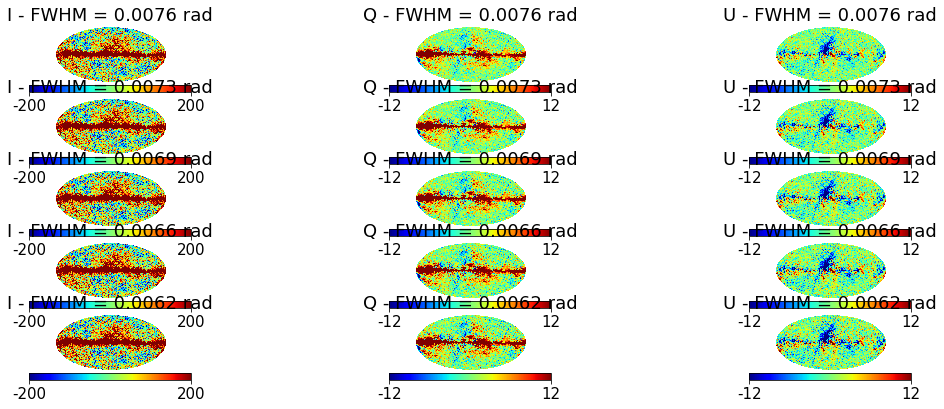

In [11]:
planck_acquisition = Acq.PlanckAcquisition(band_planck, qubic_acquisition.scene)

d_formaps = copy.deepcopy(d_TOD)
d_formaps['nf_recon'] = Nf_recon
d_formaps['nf_sub'] = Nf_recon * fact_sub

planck_obs = integration(band_planck-35, band_planck+35, qubic_acquisition.Nsub, sky_config, d_formaps, fwhm_subbands=None) # Planck map
n_planck = planck_acquisition.get_noise()  # Planck noise

m_planck_for_tod = np.zeros((Nf_recon, 12*nside**2, 3))
m_planck_all = np.zeros((Nf_recon * fact_sub, 12*nside**2, 3))

# Convolving Planck map to QUBIC resolutions
for i in range(Nf_recon):
    
    target = allfwhm_ref[i].copy()                   # Target FWHM
    print(target)
    C = HealpixConvolutionGaussianOperator(fwhm=target)                                     # Operator
    m_planck_for_tod[i] = C(m_sub[i] + n_planck.copy() * noise_planck_level)                # Convolution

for i in range(Nf_recon*fact_sub):
    
    target = qubic_acquisition.allfwhm[i]                   # Target FWHM
    print(target)
    C = HealpixConvolutionGaussianOperator(fwhm=target)                                     # Operator
    m_planck_all[i] = C(m_sub[i] + n_planck.copy() * noise_planck_level)                    # Convolution
    
plt.figure(figsize=(15, 5))
stk = ['I', 'Q', 'U']
j=0
for i in range(Nf_recon):
    for k in range(3):
        if k == 0:
            r = 200
        else:
            r = 12
        hp.mollview(m_planck_for_tod[i, :, k], cmap='jet', sub=(Nf_recon, 3, j+1), min=-r, max=r, title=f'{stk[k]} - FWHM = {np.mean(qubic_acquisition.allfwhm[i*fact_sub:(i+1)*fact_sub]):.4f} rad')
        j+=1

plt.show()

R = ReshapeOperator(m_planck_for_tod.shape, (m_planck_for_tod.shape[0]*m_planck_for_tod.shape[1]*m_planck_for_tod.shape[2]))
TOD_PLANCK = R(m_planck_for_tod)

# Final TOD

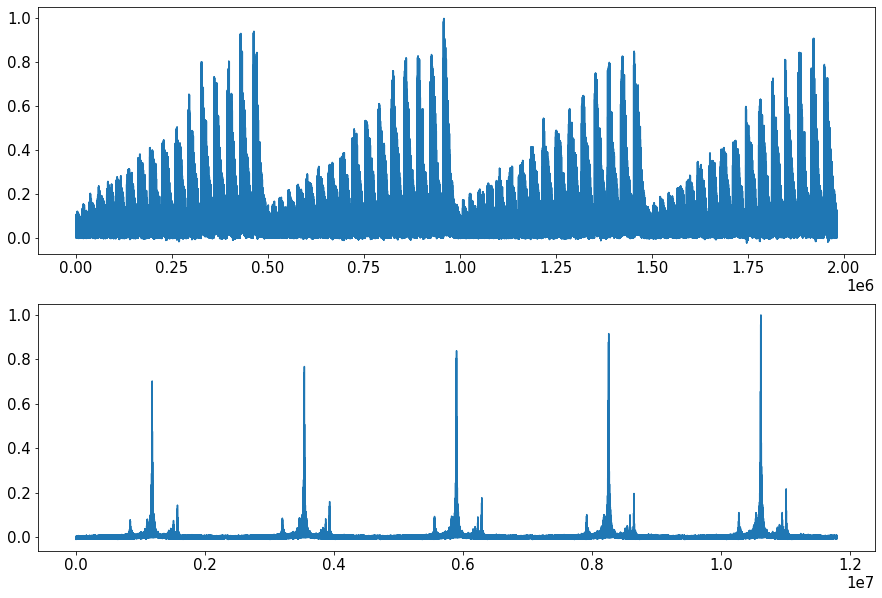

In [12]:
tod = np.r_[TOD_QUBIC, TOD_PLANCK]

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(TOD_QUBIC/TOD_QUBIC.max())

plt.subplot(2, 1, 2)
plt.plot(TOD_PLANCK/TOD_PLANCK.max())

plt.show()

In [13]:
# qubicplanck_acquisition = Acq.QubicPlanckMultiBandAcquisition(qubic_acquisition, planck_acquisition)
# myfwhm = np.array([])
# for i in range(Nf_recon):
#     myfwhm = np.append(myfwhm, np.sqrt(qubic_acquisition.allfwhm[i*fact_sub:(i+1)*fact_sub]**2 - allfwhm_ref[i]**2))

In [14]:
qubicplanck_acquisition = Acq.QubicPlanckMultiBandAcquisition(qubic_acquisition, planck_acquisition)
myfwhm = np.array([])
for i in range(Nf_recon):
    myfwhm = np.append(myfwhm, np.sqrt(qubic_acquisition.allfwhm[i*fact_sub:(i+1)*fact_sub]**2 - np.min(qubic_acquisition.allfwhm[i*fact_sub:(i+1)*fact_sub]**2)))

In [15]:
myfwhm

array([0.00171241, 0.        , 0.00162847, 0.        , 0.00154864,
       0.        , 0.00147272, 0.        , 0.00140053, 0.        ])

In [16]:
d_formaps = copy.deepcopy(d_TOD)
d_formaps['nf_recon'] = Nf_recon
d_formaps['nf_sub'] = Nf_recon * fact_sub

# QUBIC acqusition
qubic_acquisition = Acq.QubicIntegrated(d_formaps, Nsub=Nf_recon * fact_sub, Nrec=Nf_recon)

# Joint acquisition
qubicplanck_acquisition = Acq.QubicPlanckMultiBandAcquisition(qubic_acquisition, planck_acquisition)
R = ReshapeOperator((1, 786432, 3), (786432, 3))

user = 'Pierre'
M = Acq.get_preconditioner(np.ones(12*nside**2))
if user == 'full':
    
    H = qubicplanck_acquisition.get_operator(convolution=True, myfwhm=myfwhm, fixed_data=None)
    invN = qubicplanck_acquisition.get_invntt_operator(beam_correction=None, seenpix=None, mask=None)

    with rule_manager(none=True):
        if Nf_recon == 1:
            A = R.T * (H.T * invN * H) * R
            b = R.T * (H.T * invN * tod)
        else:
            A = (H.T * invN * H)
            b = (H.T * invN * tod)
        
elif user == 'Pierre':
    H = qubicplanck_acquisition.get_operator(convolution=True, myfwhm=myfwhm, fixed_data=None)
    invN = qubicplanck_acquisition.get_invntt_operator(beam_correction=None, seenpix=None, mask=None)
    
    ### Solve PCG
    U = (
        ReshapeOperator((Nf_recon * sum(seenpix) * 3), (Nf_recon, sum(seenpix), 3)) *
        PackOperator(np.broadcast_to(seenpix[None, :, None], (Nf_recon, seenpix.size, 3)).copy())
    ).T

    with rule_manager(none=True):
        if Nf_recon == 1:
            A = U.T * R.T * H.T * invN * H * R * U
            x_planck = m_planck_for_tod * (1 - seenpix[None, :, None])
            b = U.T ( R.T * H.T * invN * (tod - H(R(x_planck))))
        else:
            A = U.T * H.T * invN * H * U
            x_planck = m_planck_for_tod * (1 - seenpix[None, :, None])
            b = U.T (  H.T * invN * (tod - H(x_planck)))
    
    
    
elif user == 'Mathias':
    fixed_data = m_planck_all.copy()
    fixed_data[:, seenpix, :] = 0
    H = qubicplanck_acquisition.get_operator(convolution=False, fixed_data=fixed_data)
    invN = qubicplanck_acquisition.get_invntt_operator(beam_correction=None, seenpix=None, mask=None)
    
    A = H.T * invN * H
    b = H.T * invN * tod
elif user == 'old':
    maskinit = np.array(seenpix, dtype=float)
    index_0 = maskinit == 0
    maskinit[index_0] += 1e10

    H = qubicplanck_acquisition.get_operator(convolution=False, fixed_data=None)
    invN = qubicplanck_acquisition.get_invntt_operator(beam_correction=None, seenpix=None, mask=None)
    
    A = H.T * invN * H
    b = H.T * invN * tod
    
    #for i in range(1, Nf_recon+1):
    #    invN.operands[i].operands[1] /= DiagonalOperator(np.array([maskinit, maskinit, maskinit]).T)
else:
    raise TypeError('We would like to have more people..')

You asked 2000 pointings with repeat strategy so I will provide 666 pointings repeated 3 times.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp66.i

In [17]:
if user == 'Pierre' or user == 'Mathias':
    m_ini = m_planck_for_tod.copy()
    solution_qubic_planck = mypcg.pcg(A, b, x0=None, M=M, tol=tol, disp=True, maxiter=100)
elif user == 'full':
    solution_qubic_planck = mypcg.pcg(A, b, x0=m_planck_for_tod, M=M, tol=tol, disp=True, maxiter=100)
elif user == 'old':
    solution_qubic_planck = mypcg.pcg(A, b, x0=m_planck_for_tod[0], M=M, tol=tol, disp=True, maxiter=50)
else:
    raise TypeError('We would like to have more people..')

   1: 0.21030034615276855
   2: 0.06446104058843878
   3: 0.027800694163942808
   4: 0.0075280917851711674
   5: 0.0028512622416866635
   6: 0.0011419628562427068
   7: 0.0006195381008072755
   8: 0.00032305668726628946
   9: 0.00021236013188128777
  10: 0.00013641951280528606
  11: 8.036972660584591e-05
  12: 4.767233172637726e-05
  13: 3.017040127525178e-05
  14: 1.8582174409920723e-05
  15: 1.1317469968235522e-05
  16: 8.092588982802815e-06
  17: 8.024279411120144e-06
  18: 4.1829411516587054e-06
  19: 2.4726067652709257e-06
  20: 1.5082149224798701e-06
  21: 9.525030154604608e-07
  22: 6.118137086183223e-07
  23: 3.861484411781676e-07
  24: 2.4615985744721597e-07
  25: 1.6098316346255311e-07
  26: 1.0313698751406995e-07
  27: 6.762684259402182e-08
  28: 4.442658033377789e-08
  29: 2.8886998739821706e-08
  30: 1.9457763892944798e-08
  31: 1.6347665770583937e-08
  32: 1.2921587391460329e-08
  33: 8.704432101091912e-09
  34: 6.085616621909369e-09
  35: 3.731527602728354e-09
  36: 2.34

In [22]:
del H_TOD
gc.collect()

2646

In [21]:
import pickle
thesolution = solution_qubic_planck['x']['x'].copy()
with open('sol_with_noise.pickle', 'wb') as f:
    pickle.dump([thesolution, seenpix], f)

In [26]:
def get_inputs(m, fwhm):
    
    mean_m = np.zeros((m.shape[1], m.shape[2]))
    for i in range(m.shape[0]):
        print(fwhm[i])
        C = HealpixConvolutionGaussianOperator(fwhm=fwhm[i])
        mean_m += m[i]/m.shape[0]
    return mean_m

In [27]:
mysolution = m_planck_for_tod.copy()
if user == 'Pierre' or user == 'Mathias':
    mysolution[:, seenpix] = solution_qubic_planck['x']['x'].copy()
elif user == 'old' or user == 'full':
    mysolution = solution_qubic_planck['x']['x'].copy()
else:
    raise TypeError('We would like to have more people..')

In [28]:
mysolution.shape

(5, 786432, 3)

In [29]:
inputs0 = m_planck_for_tod[0].copy()

if user == 'Pierre' or user == 'Mathias':
    inputs0[seenpix] = get_inputs(m_sub[:fact_sub], qubic_acquisition.allfwhm[:fact_sub])[seenpix]
elif user == 'old':
    inputs0[seenpix] = get_inputs(m_sub[:fact_sub], qubic_acquisition.allfwhm[:fact_sub])[seenpix]
elif user == 'full':
    inputs0 = get_inputs(m_sub[:fact_sub], qubic_acquisition.allfwhm[:fact_sub])
else:
    raise TypeError('We would like to have more people..')
inputs = np.array([inputs0])

0.007734255838919227
0.0075423049348121015


In [30]:
C = HealpixConvolutionGaussianOperator(fwhm=allfwhm_ref[0])
myinputs = C(planck_obs[0]).copy()
print(myinputs.shape)

(786432, 3)


0
1
2
3
4


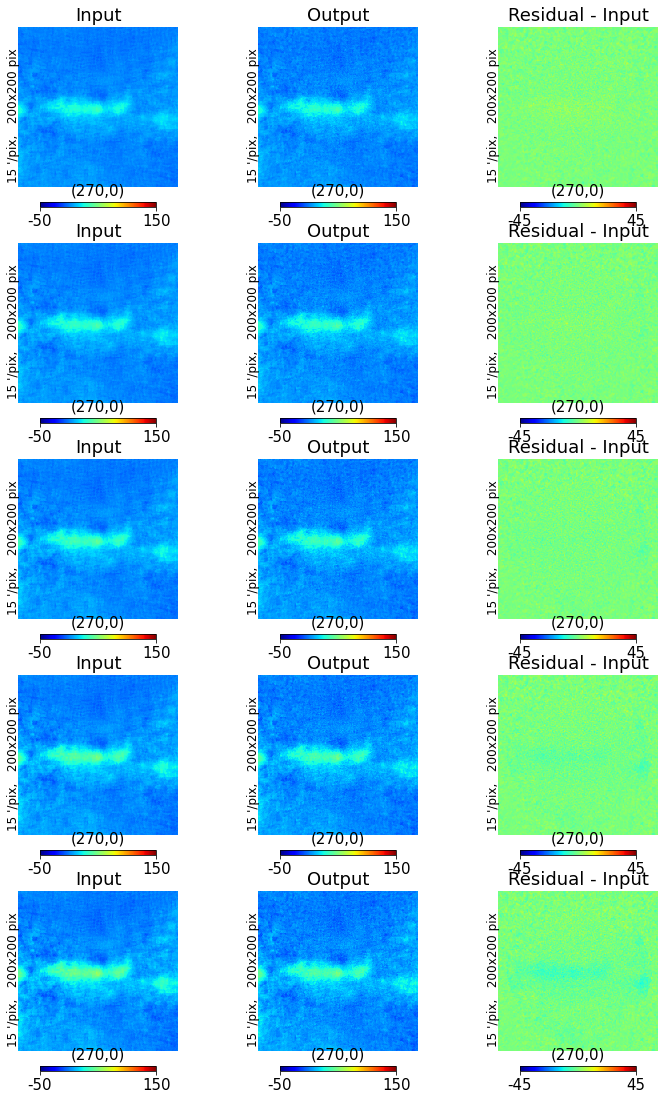

In [31]:
istk = 1

v = 50
r = 15
res = 15

plt.figure(figsize=(10, 15))



k=0
for i in range(Nf_recon):
    print(i)
    
    ### Inputs
    C = HealpixConvolutionGaussianOperator(fwhm=allfwhm_ref[i])
    myinputs = C(planck_obs[0]).copy()
    seenpix = covnorm > 0
    myinputs[seenpix] = C(np.mean(m_sub[i*fact_sub:(i+1)*fact_sub], axis=0))[seenpix]
    C = HealpixConvolutionGaussianOperator(fwhm=allfwhm_ref[i])
    n_planck_conv = C(n_planck.copy() * noise_planck_level)
    #myinputs[~seenpix] += n_planck_conv[~seenpix]
    
    ### Outputs
    mysolution = myinputs.copy()
    mysolution += n_planck_conv.copy()
    seenpix = covnorm > 0.1
    #print(mysolution.shape)
    mysolution[seenpix] = solution_qubic_planck['x']['x'][i].copy()
    
    
    hp.gnomview(myinputs[:, istk], cmap='jet', rot=center, reso=res, min=-v, max=v*3, sub=(Nf_recon, 3, k+1), title='Input')
    hp.gnomview(mysolution[:, istk], cmap='jet', rot=center, reso=res, min=-v, max=v*3, sub=(Nf_recon, 3, k+2), title='Output')

    hp.gnomview(mysolution[:, istk]-myinputs[:, istk], cmap='jet', rot=center, reso=res, title='Residual - Input', min=-90/2, max=90/2, sub=(Nf_recon, 3, k+3))
    
    k+=3
    

plt.show()

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


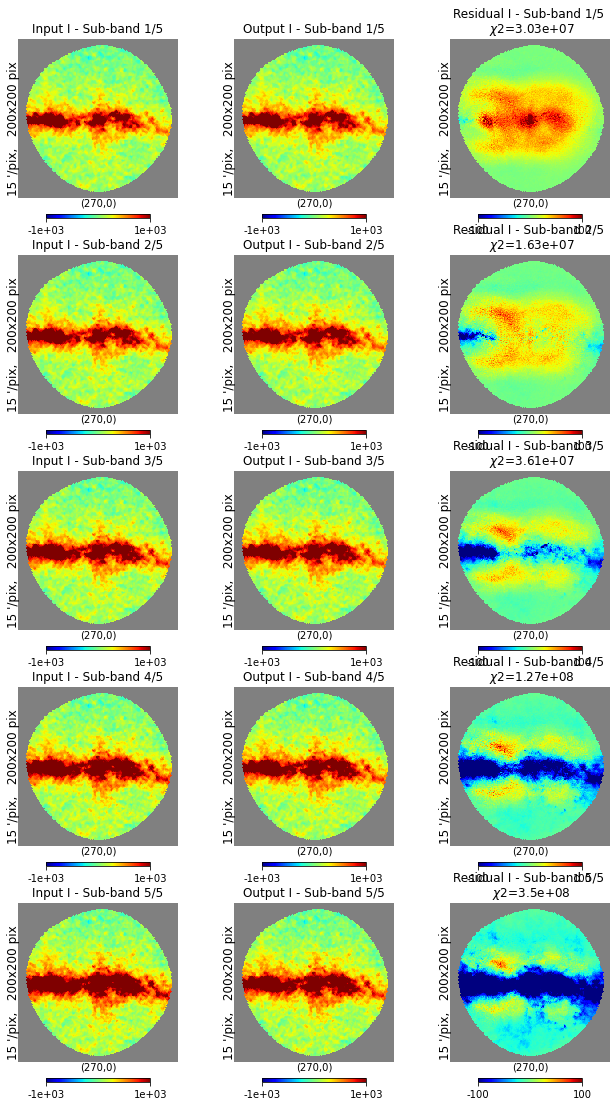

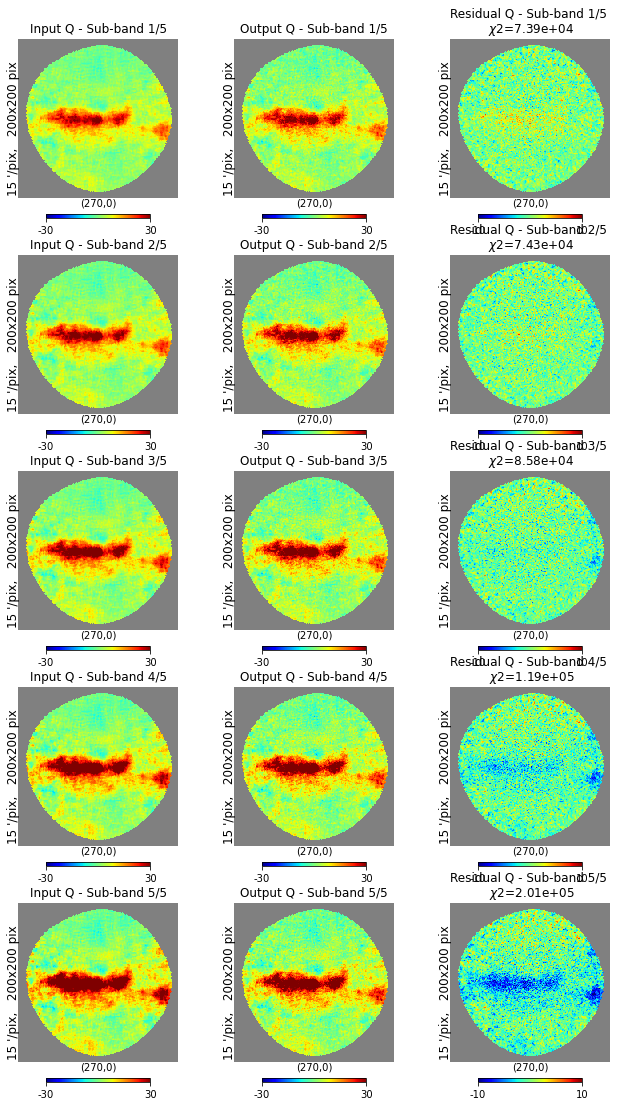

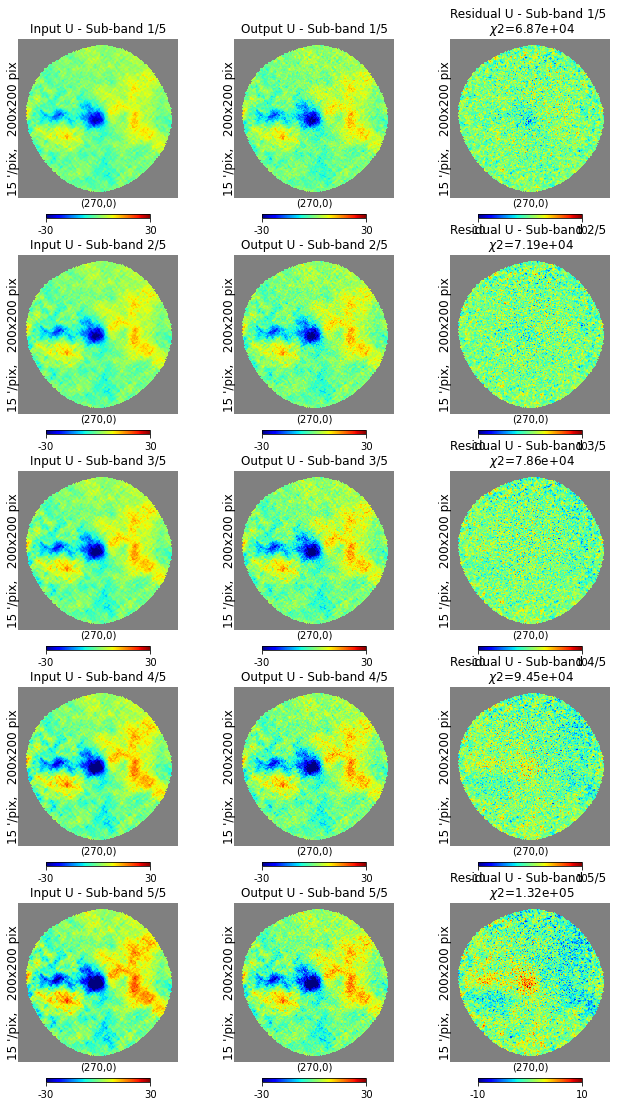

In [32]:
rc('font', size=10)
rc('figure', figsize=(20, 8))

istk = 1

v = 50
r = 15
res = 15


for istk in range(3):
    plt.figure(figsize=(9, 15))

    k=0
    for i in range(Nf_recon):
        print(i)

        ### Inputs
        C = HealpixConvolutionGaussianOperator(fwhm=allfwhm_ref[i])
        myinputs = C(planck_obs[0]).copy()
        seenpix = covnorm > 0
        myinputs[seenpix] = C(np.mean(m_sub[i*fact_sub:(i+1)*fact_sub], axis=0))[seenpix]
        C = HealpixConvolutionGaussianOperator(fwhm=allfwhm_ref[i])
        n_planck_conv = C(n_planck.copy() * noise_planck_level)
        #myinputs[~seenpix] += n_planck_conv[~seenpix]

        ### Outputs
        mysolution = myinputs.copy()
        mysolution += n_planck_conv.copy()
        seenpix = covnorm > 0.1
        #print(mysolution.shape)
        mysolution[seenpix] = solution_qubic_planck['x']['x'][i].copy()

        #v = np.std(myinputs[seenpix, istk])
        if istk == 0:
            v = 1000
            r = 100
        else:
            v = 30
            r = 10
        
        a = myinputs[:, istk]
        a[~seenpix] = hp.UNSEEN    
        hp.gnomview(a, cmap='jet', rot=center, reso=res, min=-v, max=v, sub=(Nf_recon, 3, k+1), title='Input {} - Sub-band {}/{}'.format(stk[istk], i+1, Nf_recon))

        b = mysolution[:, istk]
        b[~seenpix] = hp.UNSEEN
        hp.gnomview(b, cmap='jet', rot=center, reso=res, min=-v, max=v, sub=(Nf_recon, 3, k+2), title='Output {} - Sub-band {}/{}'.format(stk[istk], i+1, Nf_recon))

        c = b - a
        c[~seenpix] = hp.UNSEEN
        hp.gnomview(c, cmap='jet', rot=center, reso=res, title='Residual {0:} - Sub-band {1:}/{2:} \n $\chi2$={3:5.3g}'.format(stk[istk], i+1, Nf_recon, np.sum(c[seenpix]**2)), min=-r, max=r, sub=(Nf_recon, 3, k+3))

        k+=3
    
#plt.show()

In [35]:
qubicplanck_acquisition.nueff

array([134.63280448, 141.57278853, 148.8705114 , 156.54441361,
       164.61388627])

# Essai: 
### trouver les poids a mettre pour la moyenne des cartes True d'intégration dans chaque sous-bandes en essayant de minimiser le chi2 entre cartes reconstruites et cartes "vraie" (qui vont alors dependre de ces poinds). Le tout étant fait apres la reconstruction.

In [109]:
class toto:
    def __init__(self, allrecmaps, allinputmaps, seenpix, true_fwhms, weights, center, verbose=True):
        shin = np.shape(allinputmaps)
        self.nftod = shin[0]
        self.allinputmaps = allinputmaps
        
        self.seenpix = seenpix
        self.nside = hp.npix2nside(len(seenpix))

        self.verbose = verbose
        self.center = center
        
        self.true_fwhms = true_fwhms
        self.weights = weights
        
        self.nfrec = np.shape(allrecmaps)[0]
        self.allrecmaps = np.zeros((self.nfrec, 12*self.nside**2, 3))
        self.allrecmaps[:,self.seenpix] = allrecmaps
        
        self.fact_integ = self.nftod // self.nfrec
        
        
        self.allinputmaps_convolved = self.convolve_maps(self.allinputmaps, self.true_fwhms)
        
        self.mapsrec, self.true_maps, self.diffmaps, self.chi2each, self.chi2band, self.chi2 = self.get_maps(self.weights)

        
    def make_average(self, maps, weights):
        if self.verbose:
            print('      - Weighted average with:',weights)
        sumweights = np.sum(weights)
        return np.sum((weights * maps.T).T, axis=0) / np.sum(weights)

    def convolve_maps(self, maps, fwhms):
        outmaps = np.zeros_like(maps)
        for i,f in enumerate(fwhms):
            if self.verbose:
                print('      - Convolving map {} to {} deg'.format(i,f))
            C = HealpixConvolutionGaussianOperator(fwhm=f, pol=True)
            outmaps[i,:,:] = C(maps[i,:,:])
        return outmaps
    
    def compute_true_maps(self, weights):
        if self.verbose:
            print('Computing True Maps')
        true_maps = np.zeros((self.nfrec, 12*self.nside**2, 3))
        for k in range(self.nfrec):
            # 1/ Convolve input maps to the fmwhm
            if self.verbose:
                print('Reco Band {}'.format(k))
            mapsinteg = self.allinputmaps_convolved[k*self.fact_integ:(k+1)*self.fact_integ, :, :]
            # 2/ Compute the weighted average
            if self.verbose:
                print('  * Weighted average:')
            true_maps[k,:,:] = self.make_average(mapsinteg, weights[k*self.fact_integ:(k+1)*self.fact_integ])
        return true_maps
    
    def get_maps(self, weights):
        ### Reco maps
        mapsrec = self.allrecmaps.copy()
        mapsrec[:,~self.seenpix,:] = hp.UNSEEN

        ### True Maps
        true_maps = self.compute_true_maps(weights)
        true_maps[:,~self.seenpix,:] = hp.UNSEEN
        
        ### Diff Maps
        diffmaps = mapsrec - true_maps
        diffmaps[:,~self.seenpix,:] = hp.UNSEEN
    
        chi2each = np.sum(diffmaps[:,self.seenpix,:]**2, axis=1)
        chi2band = np.sum(chi2each, axis=1)
        chi2 = np.sum(chi2band)
        return mapsrec, true_maps, diffmaps, chi2each, chi2band, chi2
    
    def get_chi2(self, weights_after_first):
        weights = np.insert(weights_after_first, 0, 1)
        _,_,_,_,_, ch2 = self.get_maps(weights)
        return ch2
    
    def plot_all(self, **kwargs):
        stk = ['I', 'Q', 'U']
        for s in range(3):
            plt.figure(figsize=(9, 15))  
            if s==0:
                v = 1000
                r = 100
            else:
                v = 30
                r = 10
            for i in range(self.nfrec):
                hp.gnomview(self.true_maps[i,:,s], rot=center, sub=(self.nfrec, 3, 3*i+1), title='Input {} sub {}/{}'.format(stk[s], i+1, self.nfrec), min=-v, max=v, **kwargs)
                hp.gnomview(self.mapsrec[i,:,s], rot=center, sub=(self.nfrec, 3, 3*i+2), title='Output {} sub {}/{}'.format(stk[s], i+1, self.nfrec), min=-v, max=v,**kwargs)
                hp.gnomview(self.diffmaps[i,:,s], rot=center, sub=(self.nfrec, 3, 3*i+3), title='Diff {0:} sub {1:}/{2:} \n$\chi^2$={3:5.3g}'.format(stk[s], i+1, self.nfrec, self.chi2each[i,s]), min=-r, max=r,**kwargs)
            tight_layout()
            
        
        
    

[0.00744871 0.00744871 0.00744871 0.00744871 0.00708357 0.00708357
 0.00708357 0.00708357 0.00673633 0.00673633 0.00673633 0.00673633
 0.00640611 0.00640611 0.00640611 0.00640611 0.00609208 0.00609208
 0.00609208 0.00609208]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
      - Convolving map 0 to 0.0074487114281166274 deg
      - Convolving map 1 to 0.0074487114281166274 deg
      - Convolving map 2 to 0.0074487114281166274 deg
      - Convolving map 3 to 0.0074487114281166274 deg
      - Convolving map 4 to 0.0070835710710199186 deg
      - Convolving map 5 to 0.0070835710710199186 deg
      - Convolving map 6 to 0.0070835710710199186 deg
      - Convolving map 7 to 0.0070835710710199186 deg
      - Convolving map 8 to 0.006736330115942928 deg
      - Convolving map 9 to 0.006736330115942928 deg
      - Convolving map 10 to 0.006736330115942928 deg
      - Convolving map 11 to 0.006736330115942928 deg
      - Convolving map 12 to 0.006406111123330048 deg
      - Convo

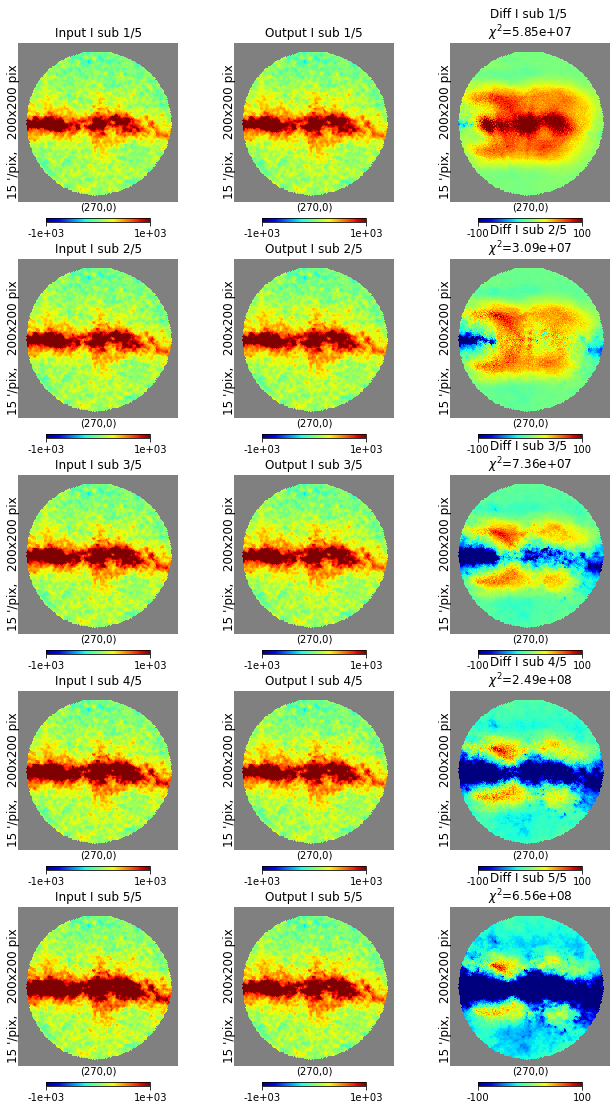

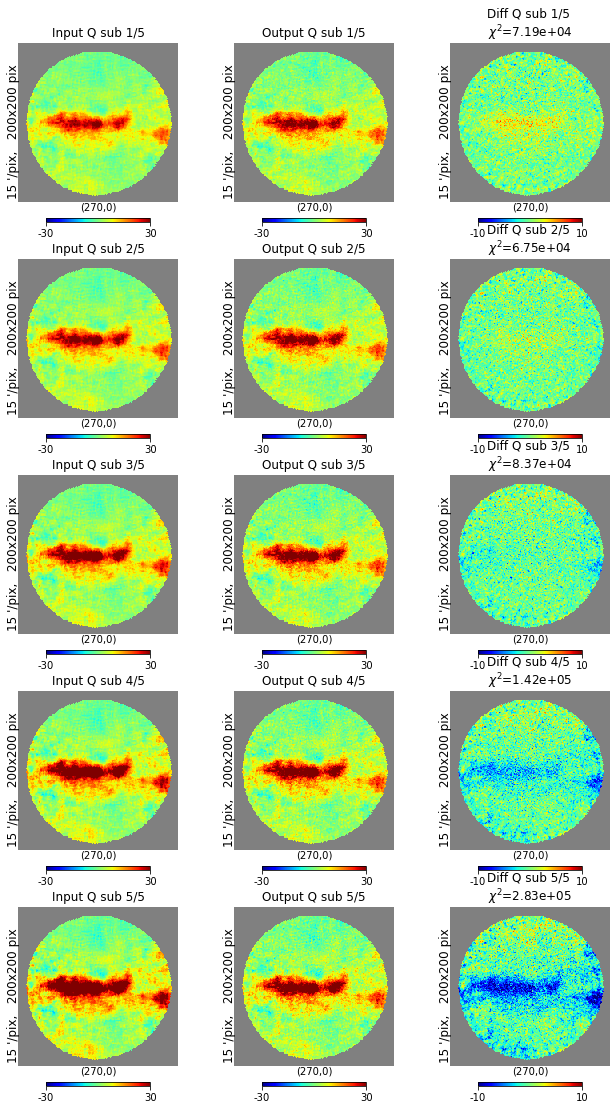

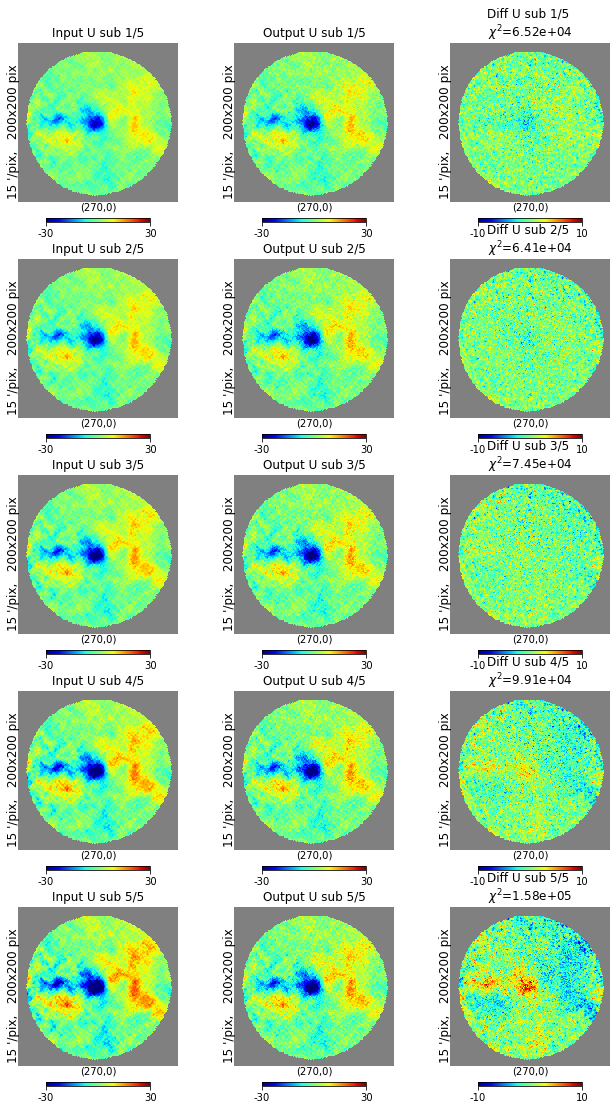

In [88]:
rc('font', size=10)
rc('figure', figsize=(20, 8))
myfwhms = allfwhm_ref.T.repeat(fact_sub)
myweights = np.ones(Nf_TOD)
print(myfwhms)
print(myweights)
mytoto = toto(solution_qubic_planck['x']['x'], m_sub, seenpix, myfwhms, myweights, center, verbose=True)
print(mytoto.chi2each)
print(mytoto.chi2band)
print(mytoto.chi2)

mytoto.plot_all(reso=15, cmap='jet')




In [110]:
rc('font', size=10)
rc('figure', figsize=(20, 8))
myfwhms = allfwhm_ref.T.repeat(fact_sub)
deltas = qubic_acquisition.nus_edge[1:]-qubic_acquisition.nus_edge[:-1]
myweights = (tod_nus_edge[1:] - tod_nus_edge[:-1])

mytoto2 = toto(solution_qubic_planck['x']['x'], m_sub, seenpix, myfwhms, myweights, center, verbose=False)
# mytoto2.plot_all(reso=15, cmap='jet')
#print(mytoto2.chi2each)
#print(mytoto2.chi2band)

print('With deltas as weights')
print(mytoto2.chi2)
print('Uniform weights')
print(mytoto.chi2)


With deltas as weights
1072591781.6791075
Uniform weights
1068343301.9497653
183279715.8453893


In [111]:
from scipy.optimize import minimize

initvals = myweights[1:]
res = minimize(mytoto2.get_chi2, x0=initvals, bounds=19*[(0,np.inf)])

In [123]:
print('With deltas as weights')
print(mytoto2.chi2)
print('Uniform weights')
print(mytoto.chi2)
print(res['fun'])
goodweights = np.insert(res['x'], 0, 1)
print()
print(goodweights)

With deltas as weights
671885582.9107685
Uniform weights
1068343301.9497653
671885582.9107685

[1.00000000e+00 0.00000000e+00 0.00000000e+00 5.16118170e+03
 5.02085031e+01 5.39329305e+01 6.16741990e+01 7.48704137e+01
 1.21208256e+03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.45665866e+03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.62094721e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00]


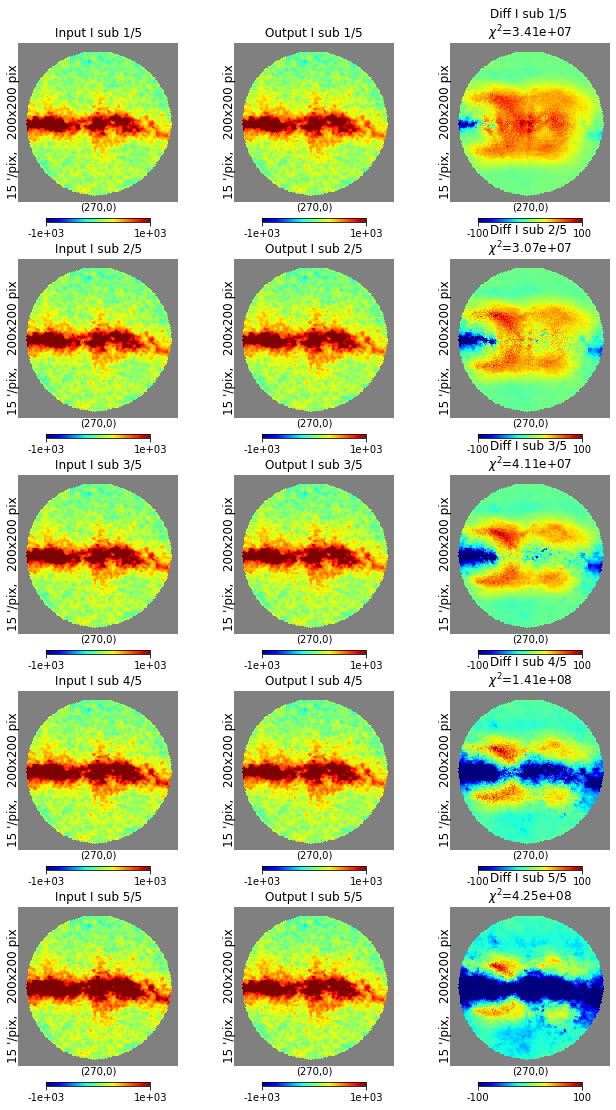

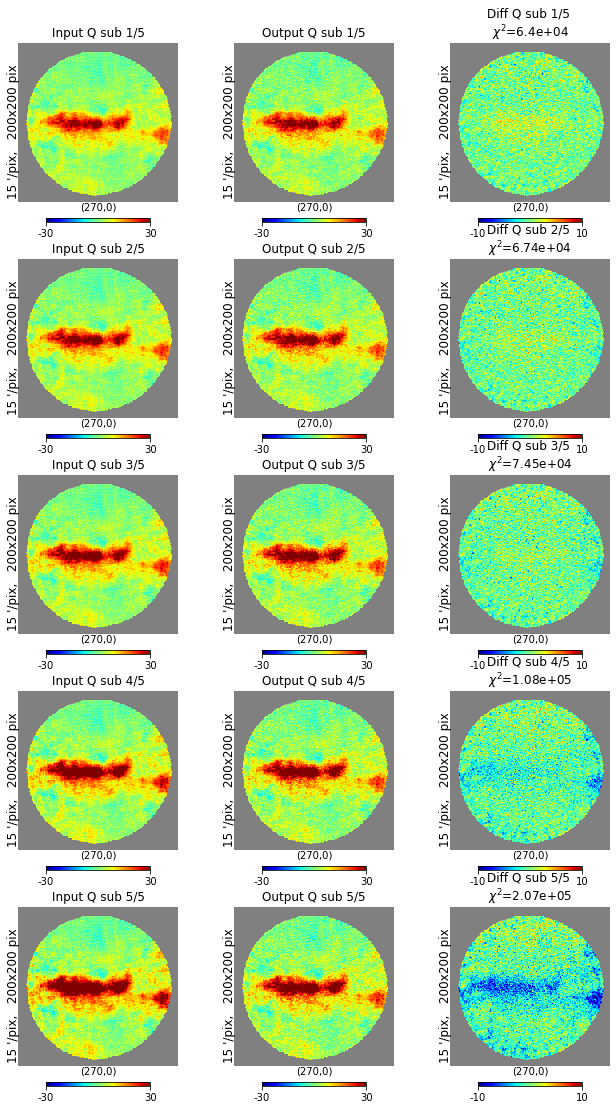

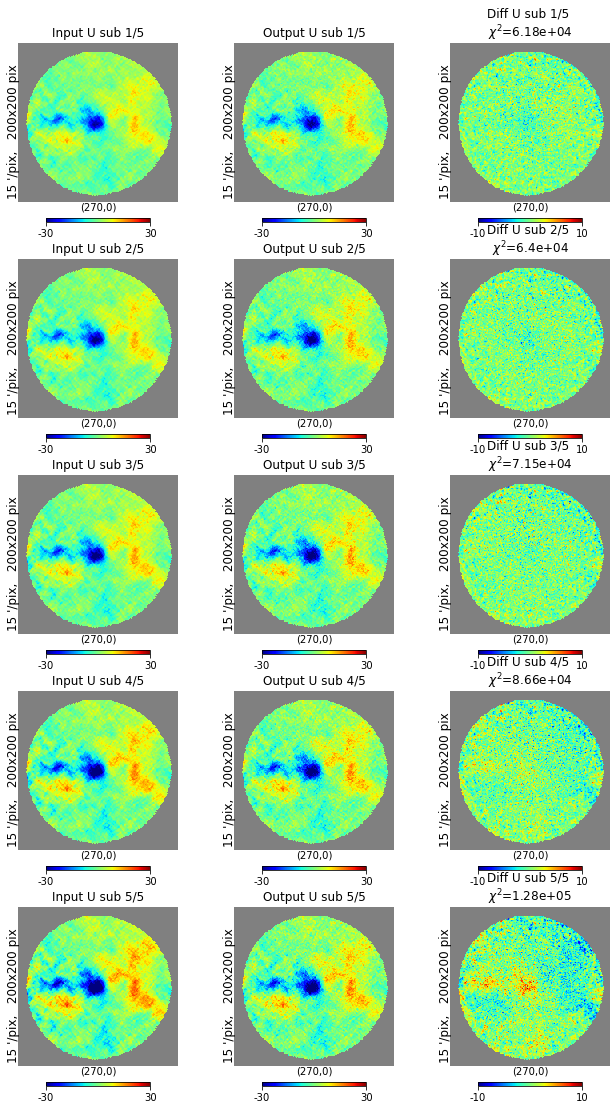

In [114]:
mytoto2 = toto(solution_qubic_planck['x']['x'], m_sub, seenpix, myfwhms, goodweights, center, verbose=False)
mytoto2.plot_all(reso=15, cmap='jet')
